# ECE381K Final Project

The goal of this project is to communicate over a real baseband channel with impulse response:
$$
h[n] = \begin{bmatrix}
    0.8037 & 0.7209 & -0.3179 & -0.3395 & -0.2455 & -0.0897 & -0.1079 & 0.2267 & -0.1602
\end{bmatrix}^T
$$

We will analyze given a fixed transmit filter and matched receiver filter $g_{TX}[n] = g_{RX}[n] = \frac{1}{\sqrt{T}}\delta[n]$, fixed signal energy per dimension $\bar{\mathcal{E}_s} = 1$, and fixed noise power per dimension $\frac{N_0}{2}=0.15$

This matched filter is suboptimal, but we will explore how effective we can be despite it

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.linalg import toeplitz # For generating U

import sys
sys.path.append('./src')

import utils, encoders, OFDM, plots

In [2]:
h = np.array([0.8037, 0.7209, -0.3179,-0.3395, -0.2455, -0.0897, -0.1079, 0.2267, -0.1062])
E_bar = 1
No = 0.15 * 2

## ISI Channel Fundamentals

For this project, we will assume T = 1
First we determine $q[n]$ and plot its frequency response

First, we find the pulse response
$$
g_{TX}[n] = \frac{1}{\sqrt{T}}\delta[n] \\
p[n] = h[n] \ast g_{TX}[n] \\
\Longrightarrow p[n] = h[n] \\
$$

We can then find an expression for $q[n]$; note that 
$$
\begin{equation*}
    \begin{split}
    q[n] &\overset{\Delta}{=} T \cdot p[n] \ast \text{Unit Energy MF} \\
    \\
    \Longrightarrow q[n] &= h[n] \ast g_{MF}[n] = h[n]
    \end{split}
\end{equation*}
$$


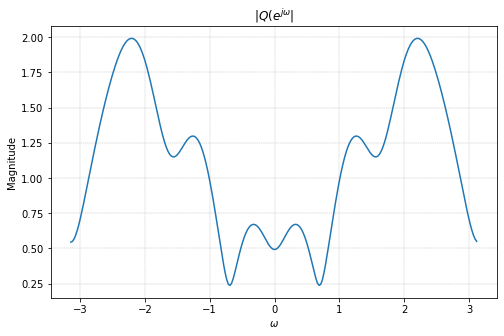

In [3]:
__n__ = 256 # Adjust to change the smoothness of the produced figure

q = h.copy()
Q = fft(q, __n__)

fig = plt.figure(figsize=(8, 5))
plt.plot(np.arange(-np.pi, np.pi, 2*np.pi/__n__), np.abs(Q))
plt.title('$|Q(e^{j\omega}|$')
plt.ylabel('Magnitude')
plt.xlabel('$\omega$')
plt.grid(True, ls='--', lw=0.4)
plt.show()


Next we determine the matched filter bound $SNR_{MFB}$ for this channel

$$
SNR_{MFB} \overset{\Delta}{=} \frac{\bar{\mathcal{E}_s} \cdot ||p||^2}{\frac{N_0}{2}}
$$

It is important for us to note that the inner product $||p||^2 = p^Tp$

In [4]:
p = h
mag_p = p @ p
snr_mfb = E_bar * mag_p / (No/2)
print(f'SNR(mfb) = {snr_mfb:.2f} ({utils.lin_to_db(snr_mfb):.2f} db)')

SNR(mfb) = 10.16 (10.07 db)


Now we can find the associated data rate for a given probability.
For example, we take $P_e < 10^{-4}$, which corresponds to a gap of $\Gamma = 6.6$ in dB.

Using the Shannon Limit for baseband channels, $b \leq \frac{1}{2}log_2(1 + \frac{SNR}{\Gamma})$, we find:

In [5]:
gap = 6.6

b = 1/2 * np.log2(1 + snr_mfb/utils.db_to_lin(6.6))
print(f'The maximum spectral efficiency we can expect on this channel is: {b:.4f} bps/Hz')

The maximum spectral efficiency we can expect on this channel is: 0.8443 bps/Hz


We can find the expected probability of error is we are to send symbols over this channel without equalization. If we transmit with 2PAM, we wil have 

$P_e = P_b \leq Q(\sqrt{SINR})$

We have 

$SINR = \frac{S}{ISI + \sigma^2}$

$S = |q[0]|^2 \cdot \bar{\mathcal{E}_s}$

$ISI = \sum_{k\neq0}{|q[k]|^2 \cdot \bar{\mathcal{E}_s}}$

$
\sigma^2 = \frac{N_0}{2}
$



In [6]:
c = 0 #len(q) // 2 # Center index, 0 since there is no 'negative' side to the matched filter

S = E_bar * (q[c] ** 2)
ISI = E_bar * np.sum((np.concatenate((q[:c], q[c+1:])) ** 2))
sig2 = No/2

SINR = S / (ISI + sig2)

Pe = utils.qfunc(np.sqrt(SINR))

print(f'S: {S}\nISI: {ISI}\nsig2: {sig2}')

print(f'The SINR we find on this channel without equalization is {SINR:0.4f} ({utils.lin_to_db(SINR):.2f} dB)')
print(f'The expected probability of error for symbol by symbol detection with no equalization is: {Pe:.5f}')

S: 0.64593369
ISI: 0.87864755
sig2: 0.15
The SINR we find on this channel without equalization is 0.6279 (-2.02 dB)
The expected probability of error for symbol by symbol detection with no equalization is: 0.21406


Now we can simulate transmission over this exact channel and determine an empirical probability of error for 100k bits

In [7]:
n_bits = 10 ** 6

pam = encoders.MPAM(M=2)
b = utils.generate_bits(n_bits)

symbols = pam.encode_bits(b)

signal = np.convolve(symbols, q)[:len(symbols)]
noise = np.sqrt(No/2) * (np.random.randn(*signal.shape))
signal = signal +  noise

b_hat = pam.decode_symbols(signal)

empirical_pe = utils.probability_of_bit_error(b, b_hat)
print(f'The empirical probability of error we simulate is: {empirical_pe:.4f}')

The empirical probability of error we simulate is: 0.2349


We can see that our empirical estimation is incredibly close to the theoretical value, off by only a few percent! This discrepancy can be explained the assumption that the ISI power acts as gaussian noise for the purposes of the SINR is not true ;)

## ZF and MMSE FIR Equalization

Here I design 33 tap ZF and MMSE FIR equalizers to improve performance

A 33 tap equalizer contains information for the 16 preceeding and succeeding symbols as well as the symbol at detection time.
Its worth noting these 16 taps come from the number of ISI taps in $q[n]$, which in this case is 8, hence the 8 bits before and after each symbol should be considered.

It then follows that 

$$
\underline{\textbf{r}}[n] \overset{\Delta}{=} \begin{bmatrix}
    z[n-16] \\
    \vdots \\
    z[n] \\
    \vdots \\
    z[n+16]
\end{bmatrix}

\hspace*{1cm}

\textbf{U} = \begin{bmatrix}
    q_8 & q_7 & q_6 & \dots & 0 \\
    0 & q_8 & q_7 & \dots & 0 \\
    \vdots & \vdots & \vdots& \ddots & \vdots\\
    0 & 0 & 0 & \dots & q_0
\end{bmatrix}

\hspace*{1cm}

\underline{\textbf{b}}[n] = \begin{bmatrix}
    b[n-24] \\
    \vdots \\
    b[n] \\
    \vdots \\
    b[n+16]
\end{bmatrix}

\hspace*{1cm}

\underline{\textbf{w}}[n] = \begin{bmatrix}
    \mathcal{w}[n-16] \\
    \vdots \\
    \mathcal{w}[n] \\
    \vdots \\
    \mathcal{w}[n+16]
\end{bmatrix}
$$

Using these formulations, we arrive at the matrix model of the channel for the 33 tap equalizer

$\underline{\textbf{r}} = \textbf{U\underline{b}} + \textbf{\underline{w}}$

Then, the Finite Impulse Response Zero-Forcing (FIR ZF) equalizer 

$\textbf{c}_{zf} = (UU^*)^{-1}\underline{u}_0$

Where $\underline{u}_0$ refers to the center column of $\textbf{U}$, equivalently this is $\underline{q}$

In [95]:
n_taps = 33
L = len(q) - 1 # Number of ISI taps

c = np.concatenate(([q[-1]], np.zeros(n_taps-1)))
r = np.concatenate((q[::-1], np.zeros(n_taps -1)))
U = toeplitz(c, r)
Czf = np.linalg.inv(U @ np.conj(U.T)) @ U[:,24]
print(Czf)

[-0.04328971  0.09084357 -0.05910059  0.02121664  0.10797077 -0.11315534
  0.18468194 -0.04554491  0.01384164  0.28056505 -0.21759791  0.27580438
  0.12913265 -0.01439734  0.46393014 -0.27604967  0.56452801  0.54137432
 -0.4343926   0.35129454 -0.29304422  0.24638095 -0.20954065  0.17265002
 -0.13965368  0.10721567 -0.08464726  0.06682991 -0.05801681  0.04744575
 -0.04255237  0.02985065 -0.01887357]


Now we estimate the SINR of the channel

We need to use the definition of our noise vector from the zf generation, and more importantly we need its autocorrelation. F is the matrix version of the matched filter, an anticausal matrix which filters the noise (whereas the signal is filtered both by the pulse response AND the matched filter, represented by q). Note that here there is no matched filter and therefore no colored noise, so F can be represented with an identity matrix

$$
\underline{\textbf{w}}[n] = \begin{bmatrix}
    \mathcal{w}[n-16] \\
    \vdots \\
    \mathcal{w}[n] \\
    \vdots \\
    \mathcal{w}[n+16]
\end{bmatrix}

\hspace*{3cm}

R_{\underline{w}} = \mathbb{E}[\underline{\textbf{w}}[0]\underline{\textbf{w}}[0]^*] = F \frac{N_0}{2} F^* = \frac{N_0}{2}I
$$

Then, we know that


$$
\begin{align}
    \sigma_{zf}^2 &= \textbf{\underline{C}}_{zf} R_{\underline{w}} \textbf{\underline{C}}_{zf}^* \\
                &= \frac{N_0}{2} \cdot \textbf{\underline{C}}_{zf} F  F^* \textbf{\underline{C}}_{zf}^*
\end{align}
$$

In [40]:
Rw = No/2 * np.eye(n_taps)
sig2_zf = Czf @ Rw @ np.conj(Czf).T
print(f'The zero forcing noise variance: {sig2_zf:.2f}')

power_vec = (Czf @ U) 
c = len(power_vec) // 2 
Pr = power_vec[c] ** 2
Pi = np.concatenate((power_vec[:c], power_vec[c+1:])) @ np.concatenate((power_vec[:c], power_vec[c+1:])).T

SINR = Pr * E_bar /  (Pi * E_bar + sig2_zf)

print(f'The corresponding SINR is : {SINR:.2f} ({utils.lin_to_db(SINR):.2f} dB)')

b = 1/2 * np.log2(1 + SINR/utils.db_to_lin(gap))

print(f'Using the same gap as previously ({gap} dB), the spectral efficiency is {b:.2f} bps/Hz')

The zero forcing noise variance: 0.25
The corresponding SINR is : 3.66 (5.63 dB)
Using the same gap as previously (6.6 dB), the spectral efficiency is 0.42 bps/Hz


Since the spectral efficiency is less than 1 bps/Hz, we are limited to 2PAM as the simplest possible form of encoding, assuming we do transmit with 2PAM, we have $P_e \leq Q(\sqrt{SINR})$

In [41]:
Pe = utils.qfunc(np.sqrt(SINR))

print(f'The theoretical probability of error we achieve is {Pe:.4f}')

The theoretical probability of error we achieve is 0.0279


While this isn't quite at the $10^{-4}$ target, we made a massive improvement over the 0.12 error with no equalization

For the minimum mean squared error FIR equalizer (MMSE FIR), we have the following formula:
*Note that since this is a baseband channel, N=1

$$
C_{mmse} = (\textbf{UU}^* + \frac{1}{\mathcal{E_s}} \textbf{R}_w)^{-1}\textbf{u}_0

\hspace*{2cm}

\mathcal{E_s} = N \cdot \overline{\mathcal{E_s}}
$$

In [106]:
Cmmse = np.linalg.inv(U@np.conj(U).T + 1/E_bar * Rw) @ U[:, 24]
print(Cmmse)

[-0.00888158  0.03160422 -0.01809668  0.01380131  0.0435099  -0.02988128
  0.07388088 -0.01334025  0.03186305  0.1329039  -0.08324737  0.13447431
  0.11232864  0.04063953  0.26618999 -0.13993005  0.44193617  0.4409138
 -0.29043719  0.14135366 -0.14957095  0.12973676 -0.18149249  0.17049115
 -0.16074046  0.09516999 -0.05610566  0.01177312 -0.00509841 -0.00156665
 -0.015659    0.01762319 -0.01945954]


In [43]:
sig2_mmse = Cmmse @ Rw @ np.conj(Cmmse).T
print(f'The zero forcing noise variance: {sig2_zf:.2f}')

power_vec = (Cmmse @ U) 
c = len(power_vec) // 2
Pr = power_vec[c] ** 2
Pi = np.concatenate((power_vec[:c], power_vec[c+1:])) @ np.concatenate((power_vec[:c], power_vec[c+1:])).T

SINR = Pr * E_bar /  (Pi * E_bar + sig2_mmse)

print(f'The corresponding SINR is : {SINR:.2f} ({utils.lin_to_db(SINR):.2f} dB)')

b = 1/2 * np.log2(1 + SINR/utils.db_to_lin(gap))

print(f'Using the same gap as previously ({gap} dB), the spectral efficiency is {b:.2f} bps/Hz')

Pe = utils.qfunc(np.sqrt(SINR))
print(f'The theoretical probability of error we achieve is {Pe:.4f}')

The zero forcing noise variance: 0.25
The corresponding SINR is : 4.48 (6.51 dB)
Using the same gap as previously (6.6 dB), the spectral efficiency is 0.49 bps/Hz
The theoretical probability of error we achieve is 0.0172


Now we simulate equalizing with both equalizers

In [105]:
n_bits = 10 ** 6

pam = encoders.MPAM(M=2)
b = utils.generate_bits(n_bits)

symbols = pam.encode_bits(b)

signal = np.convolve(symbols, h)[:len(symbols)]

noise = np.sqrt(No/2) * (np.random.randn(*signal.shape))
noisy_signal = signal + noise

signal_eq = np.convolve(noisy_signal, Czf)[17: -(n_taps - 18)]

b_hat = pam.decode_symbols(signal_eq)

empirical_pe = utils.probability_of_bit_error(b, b_hat)
print(f'The empirical probability of error using a zero-forcing equalizer we simulate is: {empirical_pe:.4f}')

The empirical probability of error using a zero-forcing equalizer we simulate is: 0.2376


In [104]:
e = np.zeros(n_taps-1)
signal_eq = np.convolve(noisy_signal, Czf)
for i in range(n_taps-1):
    b_hat = pam.decode_symbols(signal_eq[i: -(n_taps - i-1)])
    e[i] =  utils.probability_of_bit_error(b, b_hat)

e.min(), e.argmin()

(0.236894, 17)

In [107]:
# Reusing PAM and number of bits from previous simulation
b = utils.generate_bits(n_bits)
symbols = pam.encode_bits(b)

signal = np.convolve(symbols, h)[:len(symbols)]
noise = np.sqrt(No/2) * (np.random.randn(*signal.shape))
noise = np.convolve(noise, p[::-1]/np.sqrt(mag_p))[:-len(p)+1]
signal = signal +  noise

signal_eq = np.convolve(signal, Cmmse)[17: -(n_taps - 18)]

b_hat = pam.decode_symbols(signal_eq)

empirical_pe = utils.probability_of_bit_error(b, b_hat)
print(f'The empirical probability of error using an MMSE equalizer we simulate is: {empirical_pe:.4f}')

The empirical probability of error using an MMSE equalizer we simulate is: 0.2100


We achieve error nowhere near the theoretical bound for the MMSE and ZF equalizers. This is likely due to the formulation based on a causal and anticausal filter both filtering the signal. However, in this circumstance, there is only causal filtering of the signal, and no anticausal filtering is performed.

## OFDM

Here I implement a manifestation of OFDM, using N=64 subcarriers, and a cycle-prefix length v = L + 1 = 9

In [ ]:
import waterfilling

N = 64
v = 9

We begin by determining the optimal energy allocation along subchannels with waterfilling
and then calculating spectral efficiency and SNR using shannon

$$
b_n = \frac{1}{2} * log_2(1 + SNR_n)

\hspace*{2cm}

SNR_n \overset{\Delta}{=} \frac{|H_n|^2}{\sigma^2}
$$

Then, the average spectral efficiency, accounting for the cycle-prefix symbols (which contain no data), and its effective SNR:

$$
\overline{b} = \frac{b}{N+v}

\hspace*{2cm}

SNR_{ofdm} = 2^{2\overline{b}-1}
$$

In [ ]:
gains = np.abs(fft(h, N)) ** 2 / (No/2)
c = N // 2

optimal_power = waterfilling.waterfill_alloc(gains, N * E_bar)
b = 1/2 * np.log2(1 + optimal_power * gains)

plots.plot_waterfilling_info(gains[:c+1], optimal_power[:c+1], b[:c+1])

In [ ]:
b_bar = (b /  (N + v)).sum()
SNRofdm = (2**(2*b_bar)-1)
Pe = utils.qfunc(np.sqrt(SNRofdm))

print(f'The effective rate we comput is {b_bar:.4f}\nThe effective SNR this pairs to is {SNRofdm:.4f} ({utils.lin_to_db(SNRofdm):.2f} dB)')
print(f'Due to a neat property of 2PAM and QPSK, they share probability of bit errors, \n\tand therefore we can estimate the bit error with trivial computation to be Pe = {Pe:0.4f}')

This is a massive improvement over our ZF and MMSE equalizers. It's worth noting that this is not totally optimal in the sense that an SVD based equalizer will perform better on this channel, but it would require $O(N^2)$ feedback from the receiver estimating the channel to the transmitter to provide an optimal precoding, whereas OFDM only needs to feedback $O(N)$ power-allocations

In [ ]:
tx = OFDM.OFDM_transmitter(N, v)
rx = OFDM.OFDM_receiver(N, v, p)
bits_received = []
packets = 10 ** 4
bits = utils.generate_bits(N * packets)

for i in (window := trange(packets)):
    # Pass through transmitter
    bits_sent = bits[N*i:N*(i+1)]
    tx_signal = tx(bits_sent)
    
    # Pass through channel
    signal = np.convolve(tx_signal, h)[:len(tx_signal)]

    # Add AWGN noise
    # Note, the noise power is also per dimension, so the noise will be reduced accordingly
    noise = np.sqrt(No/2/N) * (np.random.randn(*signal.shape))
    noisy_signal = signal + noise

    # Pass through receiver
    b_hat = rx(noisy_signal)
    bits_received += list(b_hat)

pe = utils.probability_of_bit_error(bits, bits_received)
print(f'Empirical Pe: {pe:.8f}')

We are able to achieve much lower probability of error than with our other encoding schemes!

# Source Code
In this section, all of the source files I have referenced but not shown in this notebook have their source code at the time of project submission cut and pasted into their own cell.

% TODO